In [21]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers
from sklearn.linear_model import LinearRegression

In [11]:
# Find a list of all the datafiles
patch_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/"
patch_files = sorted(glob(join(patch_path, "*.nc")))
csv_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/"
csv_files = sorted(glob(join(csv_path, "track_step_*.csv")))

In [12]:
# Pull selected variables from patch files and join into a single DataSet
num_files = 150
train_split = int(num_files*0.7)
val_split = int(num_files*0.8)
variables = ["REFL_COM_curr"]
data_list = []
for p, patch_file in enumerate(patch_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_train = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
data_list = []
for p, patch_file in enumerate(patch_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_val = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
data_list = []
for p, patch_file in enumerate(patch_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_test = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20101024-0000_d01_model_patches.nc
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110201-0000_d01_model_patches.nc
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110326-0000_d01_model_patches.nc
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110414-0000_d01_model_patches.nc
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110425-0000_d01_model_patches.nc
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110522-0000_d01_model_patches.nc
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110605-0000_d01_model_patches.nc
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110615-0000_d01_model_patches.nc
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_2

In [13]:
# Pull variables from csv files and join into an array
csv_variables = ["major_axis_length", "minor_axis_length"]
csv_data_list = []
for p, csv_file in enumerate(csv_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_train = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_val = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_test = xr.concat(csv_data_list, dim="p").to_array().transpose()

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20101024-0000.csv
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110201-0000.csv
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110326-0000.csv
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110414-0000.csv
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110425-0000.csv
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110522-0000.csv
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110605-0000.csv
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110615-0000.csv
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTO

In [6]:
print(input_train.shape)
print(input_val.shape)
print(input_test.shape)
print(output_train.shape)
print(output_val.shape)
print(output_test.shape)

(34061, 144, 144, 1)
(4300, 144, 144, 1)
(12985, 144, 144, 1)
(34061, 2)
(4300, 2)
(12985, 2)


In [14]:
# Normalize the training data
scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
scale_stats.loc[0, "mean"] = input_train.mean()
scale_stats.loc[0, "sd"] = input_train.std()
input_train_norm = (input_train - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_val_norm = (input_val - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_test_norm = (input_test - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [15]:
# Normalize output data
output_scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
output_scale_stats.loc[0, "mean"] = output_train.mean()
output_scale_stats.loc[0, "sd"] = output_train.std()
output_train_norm = (output_train - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]
output_val_norm = (output_val - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]
output_test_norm = (output_test - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]

In [9]:
ricnn_model_1 = models.Sequential()
ricnn_model_1.add(GDL_layers.RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(144, 144, 1)))
ricnn_model_1.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model_1.add(GDL_layers.RotEquivConv2D(32, (3, 3)))
ricnn_model_1.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model_1.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model_1.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model_1.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model_1.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model_1.add(GDL_layers.RotEquivConv2D(128, (3, 3)))
ricnn_model_1.add(GDL_layers.RotInvPool())
ricnn_model_1.add(layers.Flatten())
ricnn_model_1.add(layers.Dense(32, activation='relu'))
ricnn_model_1.add(layers.Dense(2))

2022-07-13 13:48:57.178219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 13:48:57.706502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


In [10]:
ricnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 142, 142, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 71, 71, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_equiv_conv2d_1 (RotEqui  (None, 69, 69, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 34, 34, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 32, 32, 4, 64)    1

In [11]:
ricnn_model_1.compile(
    optimizer='nadam',
    loss='mse',
    metrics=['mse']
)

In [12]:
ricnn_history_1 = ricnn_model_1.fit(x=input_train_norm, y=output_train, epochs=10, validation_data=(input_val_norm, output_val))

Epoch 1/10


2022-07-13 13:49:13.475709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1065/1065 [==============================] - 75s 65ms/step - loss: 216.4437 - mse: 216.4437 - val_loss: 100.6611 - val_mse: 100.6611
Epoch 2/10
1065/1065 [==============================] - 68s 64ms/step - loss: 97.1865 - mse: 97.1865 - val_loss: 56.6782 - val_mse: 56.6782
Epoch 3/10
1065/1065 [==============================] - 68s 64ms/step - loss: 65.4712 - mse: 65.4712 - val_loss: 43.0192 - val_mse: 43.0192
Epoch 4/10
1065/1065 [==============================] - 69s 64ms/step - loss: 46.8387 - mse: 46.8387 - val_loss: 43.0780 - val_mse: 43.0780
Epoch 5/10
1065/1065 [==============================] - 68s 64ms/step - loss: 35.2926 - mse: 35.2926 - val_loss: 44.7166 - val_mse: 44.7166
Epoch 6/10
1065/1065 [==============================] - 68s 64ms/step - loss: 26.8481 - mse: 26.8481 - val_loss: 33.0154 - val_mse: 33.0154
Epoch 7/10
1065/1065 [==============================] - 68s 64ms/step - loss: 21.5170 - mse: 21.5170 - val_loss: 26.0684 - val_mse: 26.0684
Epoch 8/10
1065/1065 [=====

In [13]:
ricnn_model_2 = models.Sequential()
ricnn_model_2.add(GDL_layers.RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(144, 144, 1)))
ricnn_model_2.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model_2.add(GDL_layers.RotEquivConv2D(32, (3, 3)))
ricnn_model_2.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model_2.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model_2.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model_2.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model_2.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model_2.add(GDL_layers.RotEquivConv2D(128, (3, 3)))
ricnn_model_2.add(GDL_layers.RotInvPool())
ricnn_model_2.add(layers.Flatten())
ricnn_model_2.add(layers.Dense(32, activation='relu'))
ricnn_model_2.add(layers.Dense(2))

In [14]:
ricnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_5 (RotEqui  (None, 142, 142, 4, 32)  320       
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_4 (RotEqui  (None, 71, 71, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_6 (RotEqui  (None, 69, 69, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_5 (RotEqui  (None, 34, 34, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_7 (RotEqui  (None, 32, 32, 4, 64)   

In [15]:
ricnn_model_2.compile(
    optimizer='nadam',
    loss='mse',
    metrics=['mse']
)

In [16]:
ricnn_history_2 = ricnn_model_2.fit(x=input_train_norm, y=output_train, epochs=10, validation_data=(input_val_norm, output_val))

Epoch 1/10
1065/1065 [==============================] - 72s 64ms/step - loss: 235.3665 - mse: 235.3665 - val_loss: 196.4325 - val_mse: 196.4325
Epoch 2/10
1065/1065 [==============================] - 68s 64ms/step - loss: 113.9516 - mse: 113.9516 - val_loss: 81.8448 - val_mse: 81.8448
Epoch 3/10
1065/1065 [==============================] - 68s 64ms/step - loss: 66.4122 - mse: 66.4122 - val_loss: 42.3027 - val_mse: 42.3027
Epoch 4/10
1065/1065 [==============================] - 68s 64ms/step - loss: 47.2623 - mse: 47.2623 - val_loss: 34.8940 - val_mse: 34.8940
Epoch 5/10
1065/1065 [==============================] - 68s 64ms/step - loss: 36.0155 - mse: 36.0155 - val_loss: 32.7146 - val_mse: 32.7146
Epoch 6/10
1065/1065 [==============================] - 68s 64ms/step - loss: 28.9452 - mse: 28.9452 - val_loss: 32.7780 - val_mse: 32.7780
Epoch 7/10
1065/1065 [==============================] - 68s 64ms/step - loss: 22.2211 - mse: 22.2211 - val_loss: 26.5365 - val_mse: 26.5365
Epoch 8/10
106

In [17]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(144, 144, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(2))

In [18]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 71, 71, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)      

In [19]:
cnn_model.compile(
    optimizer='nadam',
    loss='mse',
    metrics=['mse']
)

In [20]:
cnn_history = cnn_model.fit(x=input_train_norm, y=output_train, epochs=10, validation_data=(input_val_norm, output_val))

Epoch 1/10
1065/1065 [==============================] - 13s 12ms/step - loss: 230.0032 - mse: 230.0032 - val_loss: 133.0617 - val_mse: 133.0617
Epoch 2/10
1065/1065 [==============================] - 12s 12ms/step - loss: 129.6154 - mse: 129.6154 - val_loss: 129.0811 - val_mse: 129.0811
Epoch 3/10
1065/1065 [==============================] - 12s 12ms/step - loss: 91.2862 - mse: 91.2862 - val_loss: 55.1352 - val_mse: 55.1352
Epoch 4/10
1065/1065 [==============================] - 12s 12ms/step - loss: 66.9679 - mse: 66.9679 - val_loss: 59.2203 - val_mse: 59.2203
Epoch 5/10
1065/1065 [==============================] - 12s 12ms/step - loss: 50.8492 - mse: 50.8492 - val_loss: 52.7152 - val_mse: 52.7152
Epoch 6/10
1065/1065 [==============================] - 12s 12ms/step - loss: 40.1688 - mse: 40.1688 - val_loss: 104.2335 - val_mse: 104.2335
Epoch 7/10
1065/1065 [==============================] - 12s 12ms/step - loss: 32.1359 - mse: 32.1359 - val_loss: 38.8912 - val_mse: 38.8912
Epoch 8/10

(0.0, 246.37146706581115)

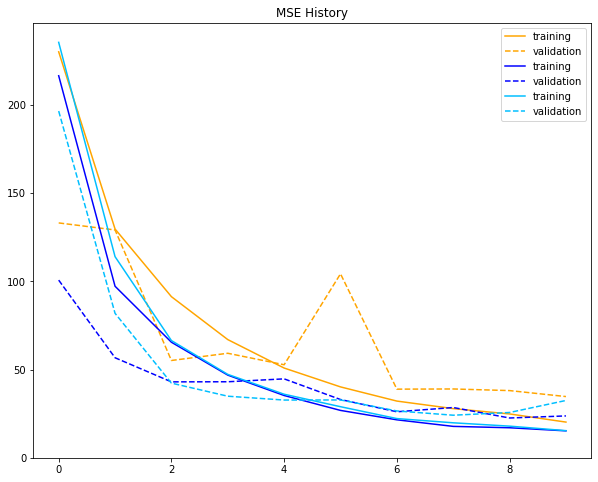

In [21]:
F, ax = plt.subplots(figsize=(10, 8))
ax = plt.gca()
a = ax.plot(cnn_history.history['mse'], label='training', color='orange')
b = ax.plot(cnn_history.history['val_mse'], label='validation', color='orange', linestyle='dashed')
c = ax.plot(ricnn_history_1.history['mse'], label='training', color='blue')
d = ax.plot(ricnn_history_1.history['val_mse'], label='validation', color='blue', linestyle='dashed')
c = ax.plot(ricnn_history_2.history['mse'], label='training', color='deepskyblue')
d = ax.plot(ricnn_history_2.history['val_mse'], label='validation', color='deepskyblue', linestyle='dashed')
ax.legend()
ax.set_title("MSE History")
ax.set_ylim(bottom=0)

In [22]:
ricnn_model_1.evaluate(input_test_norm, output_test)

406/406 [==============================] - 9s 22ms/step - loss: 32.6190 - mse: 32.6190


[32.6190071105957, 32.6190071105957]

In [23]:
ricnn_model_2.evaluate(input_test_norm, output_test)

406/406 [==============================] - 9s 22ms/step - loss: 37.6601 - mse: 37.6601


[37.66010665893555, 37.66010665893555]

In [24]:
cnn_model.evaluate(input_test_norm, output_test)

406/406 [==============================] - 3s 6ms/step - loss: 42.0649 - mse: 42.0649


[42.06492233276367, 42.06492233276367]

In [32]:
ricnn_model_1.save("saved_models/latent_to_latent_RICNN/ricnn_model_1")
ricnn_model_2.save("saved_models/latent_to_latent_RICNN/ricnn_model_2")
cnn_model.save("saved_models/latent_to_latent_RICNN/cnn_model")

INFO:tensorflow:Assets written to: saved_models/latent_to_latent_RICNN/ricnn_model_1/assets
INFO:tensorflow:Assets written to: saved_models/latent_to_latent_RICNN/ricnn_model_2/assets


INFO:tensorflow:Assets written to: saved_models/latent_to_latent_RICNN/cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/latent_to_latent_RICNN/cnn_model/assets


In [7]:
ricnn_model_1 = tf.keras.models.load_model("saved_models/latent_to_latent_RICNN/ricnn_model_1")
ricnn_model_2 = tf.keras.models.load_model("saved_models/latent_to_latent_RICNN/ricnn_model_2")
cnn_model = tf.keras.models.load_model("saved_models/latent_to_latent_RICNN/cnn_model")

In [16]:
ricnn_latent_model_1 = tf.keras.Model(ricnn_model_1.inputs, ricnn_model_1.layers[-2].output)
ricnn_latent_model_2 = tf.keras.Model(ricnn_model_2.inputs, ricnn_model_2.layers[-2].output)
cnn_latent_model = tf.keras.Model(cnn_model.inputs, cnn_model.layers[-2].output)

In [17]:
ricnn_latent_test_preds_1 = ricnn_latent_model_1.predict(input_test_norm)
ricnn_latent_test_preds_2 = ricnn_latent_model_2.predict(input_test_norm)
cnn_latent_test_preds = cnn_latent_model.predict(input_test_norm)

2022-07-14 09:59:01.212039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


406/406 [==============================] - 2s 6ms/step


In [27]:
ricnn_latent_test_preds_1.shape

(12985, 32)

In [25]:
ricnn_to_ricnn = LinearRegression()
ricnn_to_ricnn.fit(ricnn_latent_test_preds_1, ricnn_latent_test_preds_2)
ricnn_to_ricnn.score(ricnn_latent_test_preds_1, ricnn_latent_test_preds_2)

0.9346551215757468

In [26]:
cnn_to_ricnn = LinearRegression()
cnn_to_ricnn.fit(cnn_latent_test_preds, ricnn_latent_test_preds_1)
cnn_to_ricnn.score(cnn_latent_test_preds, ricnn_latent_test_preds_1)

0.8875039649714462